In [1]:
%pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/mnemonics_benchmark")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
import re

character_message = {
    "role": "system",
    "content": """
You are a human that rank orders mnemonics. The mnemonics have been constructed to help students learn Japanese Kanji and are based on its component meanings such that the Kanji meaning can be recalled easily. You are given four different mnemonics and you have to order them from most memorable to least memorable.
Output the ordered numbers separated by commas. E.g. 4,2,1,3
"""
}

keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']

def get_user_message(example):
    msg = f"Component meanings: {example['component_meanings']}\nKanji meaning: {example['kanji_meaning']}\n"
    msg += "Mnemonics:\n"
    for i, key in enumerate(keys):
        text = re.sub(r'<.*?>', '', example[key])
        msg += f"[{i+1}] {text}\n"
    
    return {
        "role": "user",
        "content": msg
    }

In [10]:
get_user_message(ds['train'][0])['content']

"Component meanings: woman,catapult\nKanji meaning: recreation\nMnemonics:\n[1] This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before\n[2] Once upon a time there was a woman who wanted to recreate her childhood memories of playing with a catapult. She went to the local store to buy one, but instead she found a cute little white cat that she just couldn't resist. She decided to take the cat home and name him Catapult. From then on, the woman and Catapult would have fun together playing games and recreating her childhood memories.\n[3] A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the m

In [13]:
import openai 

In [21]:
import openai

res = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[character_message, get_user_message(ds['train'][10])],
)

In [26]:
import time

def map_rank(example):
    res = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        messages=[character_message, get_user_message(example)],
    )
    example['model_answer'] = res['choices'][0]['message']['content']

    time.sleep(1)

    return example

In [27]:
ds_model_ranks = ds['train'].map(map_rank)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [28]:
ds_model_ranks.to_json('ds_model_ranks.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

281554

In [124]:
keyids = [1,2,3,4]


def parse_ranks(example):
    try:
        parsed = example['model_answer'][:11].replace('.','').split(',')
        parsed = [int(x) for x in parsed]
        ranks = []
        for id in keyids:
            ranks.append(parsed.index(id) + 1)
            
        example['model_ranks'] = ranks

    except:
        example['model_ranks'] = None
    return example

In [125]:
mranks = [2,3,4,1]
ids = [1,2,3,4]

for id in ids:
    print(mranks.index(id) + 1)

4
1
2
3


In [126]:
ds_ranks = ds_model_ranks.map(parse_ranks)

In [127]:
ds_ranks['model_ranks']

[[4, 1, 2, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [4, 1, 2, 3],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [3, 2, 4, 1],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [2, 1, 3, 4],
 [4, 1, 2, 3],
 [2, 1, 3, 4],
 [4, 1, 2, 3],
 [2, 1, 3, 4],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [4, 1, 3, 2],
 [4, 1, 3, 2],
 [4, 1, 3, 2],
 [2, 1, 4, 3],
 [4, 1, 2, 3],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [4, 1, 2, 3],
 [3, 1, 2, 4],
 [4, 1, 3, 2],
 [4, 1, 2, 3],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [2, 1, 4, 3],
 [2, 1, 3, 4],
 [4, 1, 3,

In [109]:
ds_ranks_filtered = ds_ranks.filter(lambda x: x['model_ranks'] is not None)

Filter:   0%|          | 0/190 [00:00<?, ? examples/s]

In [110]:
ds_ranks_filtered

Dataset({
    features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic', 'model_answer', 'model_ranks'],
    num_rows: 188
})

In [111]:
ds_ranks_filtered['model_ranks']

[[4, 1, 2, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [3, 1, 4, 2],
 [2, 1, 3, 4],
 [3, 1, 2, 4],
 [4, 1, 2, 3],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [3, 2, 4, 1],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [4, 1, 3, 2],
 [3, 1, 2, 4],
 [2, 1, 3, 4],
 [4, 1, 2, 3],
 [2, 1, 3, 4],
 [4, 1, 2, 3],
 [2, 1, 3, 4],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [2, 1, 3, 4],
 [4, 1, 3, 2],
 [4, 1, 3, 2],
 [4, 1, 3, 2],
 [2, 1, 4, 3],
 [4, 1, 2, 3],
 [2, 1, 4, 3],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [4, 1, 2, 3],
 [3, 1, 2, 4],
 [4, 1, 3, 2],
 [4, 1, 2, 3],
 [4, 1, 2, 3],
 [4, 1, 3, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [3, 1, 4, 2],
 [2, 1, 4, 3],
 [2, 1, 3, 4],
 [4, 1, 3,

In [112]:
import numpy as np

np.array(ds_ranks_filtered['model_ranks']).T.shape

(4, 188)

In [113]:
from scipy.stats import friedmanchisquare

f_stat, p_value = friedmanchisquare(*np.array(ds_ranks_filtered['model_ranks']).T)

In [114]:
f_stat, p_value

(340.1297872340424, 2.0454496679184383e-73)

In [123]:
np.array(ds_ranks_filtered['model_ranks']).T

array([[4, 3, 3, 2, 3, 2, 2, 3, 3, 3, 4, 3, 3, 4, 3, 3, 2, 3, 3, 2, 3, 4,
        4, 4, 2, 3, 4, 2, 4, 3, 2, 4, 2, 4, 2, 2, 3, 3, 3, 4, 4, 2, 4, 4,
        4, 2, 4, 2, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2,
        4, 3, 4, 2, 2, 4, 4, 4, 3, 3, 2, 3, 3, 4, 2, 4, 2, 3, 2, 2, 3, 2,
        2, 4, 3, 4, 3, 2, 3, 3, 4, 3, 3, 2, 3, 4, 2, 4, 3, 3, 3, 4, 4, 3,
        3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 2, 3, 2, 2, 4, 3, 4, 3, 3, 3, 2,
        2, 3, 4, 4, 4, 3, 2, 3, 4, 2, 3, 3, 4, 3, 4, 2, 4, 2, 2, 2, 4, 4,
        3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 4, 4, 2, 2, 3, 4, 2, 2, 4, 3, 3, 4,
        3, 3, 4, 2, 3, 2, 2, 4, 2, 2, 4, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [130]:
print(keys)
print(np.array(ds_ranks_filtered['model_ranks']).T.mean(axis=1))

['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']
[3.02659574 1.00531915 3.11702128 2.85106383]


In [132]:
print(keys)
print(np.array(ds_ranks_filtered['model_ranks']).T.std(axis=1))

['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']
[0.760973   0.07273827 0.81025847 0.86242418]


array([[<Axes: title={'center': '0'}>]], dtype=object)

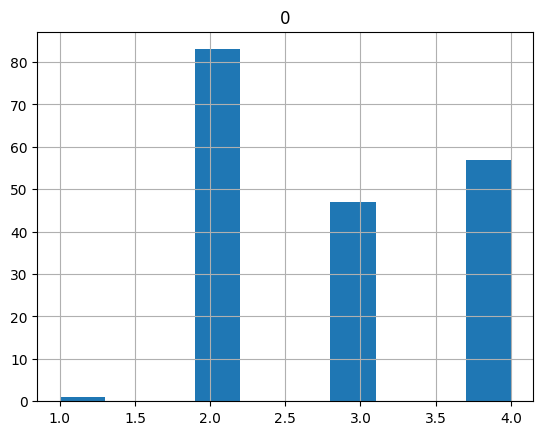

In [142]:
import pandas as pd
pd.DataFrame(np.array(ds_ranks_filtered['model_ranks']).T[3]).hist()

In [157]:
get_user_message(ds_ranks_filtered.filter(lambda x: x['model_ranks'][3] == 4)[25])['content']

"Component meanings: coat rack,bundle\nKanji meaning: neglect\nMnemonics:\n[1] This is a coat rack that I made for my daughter's bedroom. It was bundle of neglect at first, but it turned out to be so much fun! She loves hanging her coats from the hooks and she can hang them all day long without feeling like they're falling off or getting tangled up in each other (I'm not sure if this\n[2] Once upon a time there was a coat rack that had been neglected for many years. It was so neglected that it had become a bundle of sticks and was no longer of any use. One day, a kind-hearted soul saw the neglected coat rack and decided to take it home and give it the love and care that it deserved. With a bit of effort and a lot of love, the coat rack was restored to its former glory. From then on, it was a reminder of the importance of not neglecting the things we care about.\n[3] I walked into the room and noticed a neglected coat rack in the corner, with a bundle of coats hanging from it. It was cl

In [136]:
np.array(ds_ranks_filtered['model_ranks']).T.max(axis=1)

array([4, 2, 4, 4])

In [137]:
import time

def map_rank(example):
    res = openai.ChatCompletion.create(
        model='gpt-4',
        messages=[character_message, get_user_message(example)],
    )
    example['model_answer'] = res['choices'][0]['message']['content']

    time.sleep(2)

    return example

In [139]:
get_user_message(ds['train'][10])['content']

"Component meanings: canopy,tree,stone\nKanji meaning: polish\nMnemonics:\n[1] This is a rush transcript. Copy may not be in its final form\n tree canopy of the stone circle at Stonehenge by polisharchitecture on Flickr, used under Creative Commons license (CC BY-NC) This interview has been edited for length and clarity The following are excerpts from an hourlong conversation between Democracy Now!'s Amy Goodman\n[2] Once upon a time, there was a canopy of trees that stretched across the horizon. Underneath the canopy, there was a large stone. Every day, the stone was polished until it shined brightly. Eventually, it became so polished that it glistened in the sunlight beneath the canopy of trees.\n[3] The canopy of the tree was so lush and inviting that it seemed to be calling out to me. I stepped closer and noticed a smooth stone beneath my feet, as if it had been polished by the hands of time. I looked up and marveled at the beauty of the tree, and the way the sunlight filtered thro

In [138]:
ds['train'].select(range(1)).map(map_rank)['model_answer']

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

InvalidRequestError: The model: `gpt-4` does not exist

You are a human that rank orders mnemonics. The mnemonics have been constructed to help students learn Japanese Kanji and are based on its component meanings such that the Kanji meaning can be recalled easily. You are given four different mnemonics and you have to order them from most memorable to least memorable.
Output the ordered numbers separated by commas. E.g. 4,2,1,3


Component meanings: moon,power\nKanji meaning: armpit\nMnemonics:\n
[1] It's been armpit time for a while now, but moon power has finally arrived in the form of solar panels that can be installed on your home or business. The technology is called photovoltaics (PV), and it works by harnessing sunlight to generate electricity from light-emitting diodes known as PV cells\n
[2] Once upon a time there was a man who lived on the moon. He was so powerful that he could lift a car with one arm. He was so strong that his armpit could hold the weight of a small planet. He used his moon powers to help people in need and the people of the moon were grateful.\n
[3] The moon has a mysterious power that can be felt in the armpit of the night. As we gaze upon its beauty, we can't help but feel a sense of awe and wonder. The moon has an undeniable power that can be seen in its ability to light up the darkness and bring us peace.\n
[4] The moon has a lot of power that is power it gets from the power of every armpit of every human on earth! Why does your armpit smell? It’s because the moon is draining the power from your armpit. The moon saps power from your armpit and that power is sucked up into the sky where the moon collects the power for its own devices. Imagine an aura of stinky power traveling from your armpit to the moon. Feel the power leaving you as the moon saps your power through your armpits.\n


Based on my analysis of the given mnemonics, the ordered numbers from most memorable to least memorable are: 2, 3, 1, 4.

Here's why I think so:

Mnemonic [2] personifies the Kanji by creating a story of a powerful man living on the moon, whose armpit is strong enough to hold a planet. This creates a vivid and engaging image that's easy to remember, making it the most memorable of the four.

Mnemonic [3] also makes use of imagery and connects the power of the moon with the feeling in one's armpit at night. This association is unique and interesting, making it the second most memorable mnemonic.

Mnemonic [1] explains the meaning of the Kanji using technical terminology, photovoltaics, which may be difficult for some students to remember. However, it does create a clear and logical connection between the Kanji meaning and the component meanings of moon and power. This makes it the third most memorable mnemonic.

Mnemonic [4] connects the moon's power with the smell of one's armpit, which may not be the most appealing association. Additionally, the explanation provided for the Kanji meaning is not as clear or memorable as the other mnemonics. Therefore, it's the least memorable of the four.

GPT 4

[2] Ranked 1st: This mnemonic creates a vivid and engaging story about a man who lived on the moon with incredible power. It directly relates the component meanings (moon and power) to the Kanji meaning (armpit) by stating that the man's armpit could hold the weight of a small planet. The imagery of the man's strength and the connection to the moon make this mnemonic memorable.

[3] Ranked 2nd: This mnemonic ties the component meanings to the Kanji meaning by using poetic language and creating an atmosphere of awe and wonder. It describes the moon's power as something that can be felt in the "armpit of the night," making the connection to the Kanji meaning. While it may not be as striking as the story in mnemonic 2, it is still memorable because of its poetic nature.

[4] Ranked 3rd: This mnemonic takes a humorous approach, suggesting that the moon draws its power from the armpits of humans on Earth. The concept of "stinky power" being sapped from one's armpit creates a quirky image that can help with memorization. However, the direct connection between the component meanings and the Kanji meaning is not as strong as in the first two mnemonics.

[1] Ranked 4th: This mnemonic primarily focuses on solar panels and photovoltaics, which are unrelated to the Kanji meaning (armpit) and the component meanings (moon, power). The phrase "armpit time" is used, but it does not make a strong connection between the component meanings and the Kanji meaning. As a result, this mnemonic is the least memorable of the four.